**Step 1: Load the Dataset**

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-40f80292828d4b(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

data/train-00001-of-00004-de395cdb9595cd(…):   0%|          | 0.00/375M [00:00<?, ?B/s]

data/train-00002-of-00004-8b746b230324f3(…):   0%|          | 0.00/533M [00:00<?, ?B/s]

data/train-00003-of-00004-402d3c6cb6e672(…):   0%|          | 0.00/593M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'organ', 'label'],
        num_rows: 25000
    })
})
{'image': Image(mode=None, decode=True), 'organ': ClassLabel(names=['lung', 'colon']), 'label': ClassLabel(names=['benign', 'adenocarcinomas', 'squamous carcinomas'])}


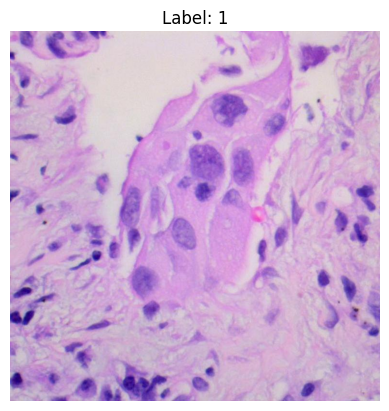

In [ ]:
# --- Install dependencies ---
!pip install datasets torch torchvision matplotlib tqdm --quiet

# --- Import libraries ---
from datasets import load_dataset
import matplotlib.pyplot as plt

# --- Load LC25000 from Hugging Face ---
dataset = load_dataset("1aurent/LC25000")

# --- Inspect structure ---
print(dataset)
print(dataset['train'].features)

# --- View a sample image ---
sample = dataset['train'][0]
img = sample['image']
label = sample['label']

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


**SECTION 2 — Dataset Loading & Exploration**

Loaded 3000 images (≈1000 per class).


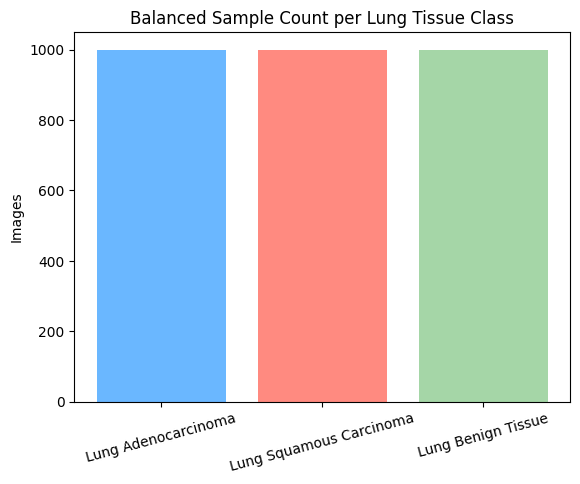

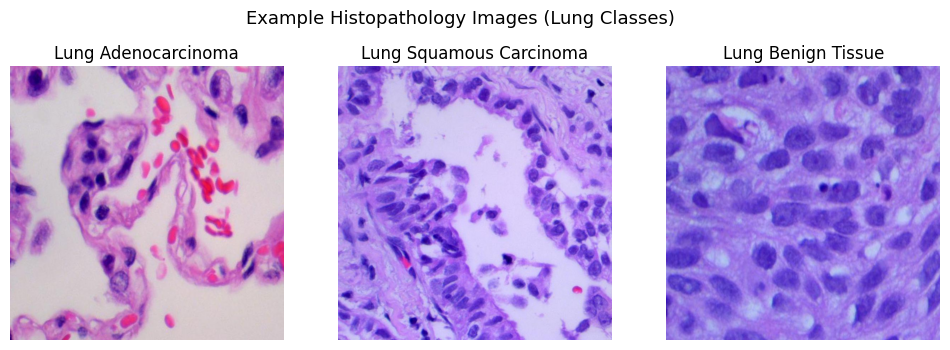

In [ ]:
# ==========================================================
# SECTION 2 — STREAMED BALANCED SAMPLING (FINAL FIX)
# ==========================================================
!pip install datasets torch torchvision matplotlib tqdm --quiet

from datasets import load_dataset
import matplotlib.pyplot as plt
import random

# ----------------------------------------------------------
# Stream the dataset (no full load)
# ----------------------------------------------------------
stream_ds = load_dataset("1aurent/LC25000", split="train", streaming=True)

label_map = {0: "Lung Adenocarcinoma", 1: "Lung Squamous Carcinoma", 2: "Lung Benign Tissue"}

# ----------------------------------------------------------
# Collect a balanced subset: e.g. 1000 per class
# ----------------------------------------------------------
target_per_class = 1000
dataset = {0: [], 1: [], 2: []}

for example in stream_ds:
    lbl = example["label"]
    if len(dataset[lbl]) < target_per_class:
        dataset[lbl].append(example)
    # stop when all classes reached target
    if all(len(v) >= target_per_class for v in dataset.values()):
        break

# Flatten into a single list
subset = dataset[0] + dataset[1] + dataset[2]
print(f"Loaded {len(subset)} images (≈{target_per_class} per class).")

# ----------------------------------------------------------
# Bar chart of class counts
# ----------------------------------------------------------
counts = {label_map[k]: len(v) for k, v in dataset.items()}
plt.bar(counts.keys(), counts.values(), color=['#6ab7ff','#ff8a80','#a5d6a7'])
plt.title("Balanced Sample Count per Lung Tissue Class")
plt.ylabel("Images")
plt.xticks(rotation=15)
plt.show()

# ----------------------------------------------------------
# Display one random sample per class
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, i in zip(axes, label_map):
    sample = random.choice(dataset[i])
    ax.imshow(sample["image"])
    ax.set_title(label_map[i])
    ax.axis("off")
plt.suptitle("Example Histopathology Images (Lung Classes)", fontsize=13)
plt.show()


**SECTION 3 — Pre-processing, Splits & PyTorch DataLoaders**

TRAIN size: 2100
  VAL size: 450
 TEST size: 450
Batches — train/val/test: 66 15 15
Train class counts: {'Lung Adenocarcinoma': 700, 'Lung Squamous Carcinoma': 700, 'Lung Benign Tissue': 700}
Val class counts: {'Lung Adenocarcinoma': 150, 'Lung Squamous Carcinoma': 150, 'Lung Benign Tissue': 150}
Test class counts: {'Lung Adenocarcinoma': 150, 'Lung Squamous Carcinoma': 150, 'Lung Benign Tissue': 150}


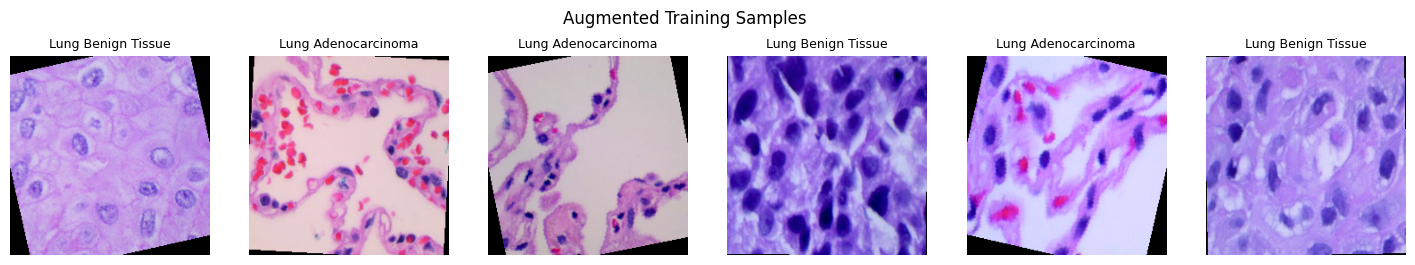

In [ ]:
# ==========================================================
# SECTION 3 — PRE-PROCESSING, SPLITS & DATALOADERS
# ==========================================================
# Uses the variables created earlier:
#   - dataset: {0: [examples...], 1: [...], 2: [...]}
#   - label_map: {0:"Lung Adenocarcinoma", 1:"Lung Squamous Carcinoma", 2:"Lung Benign Tissue"}

import random, math
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# -----------------------------
# 3.1  Create balanced splits
# -----------------------------
def split_per_class(d, train=0.70, val=0.15, test=0.15, seed=42):
    random.seed(seed)
    splits = {"train": [], "val": [], "test": []}
    for cls, items in d.items():
        items = items.copy()
        random.shuffle(items)
        n = len(items)
        n_train = int(train * n)
        n_val   = int(val * n)
        train_items = items[:n_train]
        val_items   = items[n_train:n_train+n_val]
        test_items  = items[n_train+n_val:]
        splits["train"].extend(train_items)
        splits["val"].extend(val_items)
        splits["test"].extend(test_items)
    # final shuffle for each split
    for k in splits:
        random.shuffle(splits[k])
    return splits

splits = split_per_class(dataset, train=0.70, val=0.15, test=0.15, seed=42)
for k in splits:
    print(f"{k.upper():>5} size:", len(splits[k]))

# -----------------------------
# 3.2  Transforms (ImageNet norm)
# -----------------------------
IM_SIZE = 224
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IM_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IM_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# -----------------------------
# 3.3  PyTorch Dataset wrapper
# -----------------------------
class LC25000Torch(Dataset):
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        ex = self.items[idx]
        image = ex["image"]      # PIL.Image
        label = int(ex["label"]) # 0,1,2
        if self.transform:
            image = self.transform(image)
        return image, label

ds_train = LC25000Torch(splits["train"], transform=train_tfms)
ds_val   = LC25000Torch(splits["val"],   transform=eval_tfms)
ds_test  = LC25000Torch(splits["test"],  transform=eval_tfms)

# -----------------------------
# 3.4  DataLoaders
# -----------------------------
BATCH_SIZE = 32  # safe for Colab; adjust if needed
NUM_WORKERS = 2  # set to 0 on Windows local if you see issues

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

print("Batches — train/val/test:",
      len(dl_train), len(dl_val), len(dl_test))

# -----------------------------
# 3.5  Quick sanity checks
# -----------------------------
# Class distribution per split
def count_labels(items):
    c = {0:0,1:0,2:0}
    for ex in items:
        c[int(ex["label"])] += 1
    return c

for split_name in ["train","val","test"]:
    counts = count_labels(splits[split_name])
    pretty = {label_map[k]: v for k,v in counts.items()}
    print(f"{split_name.title()} class counts:", pretty)

# Visualize a few TRAIN augmentations
def show_batch(dset, n=6):
    idxs = random.sample(range(len(dset)), n)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for ax, i in zip(axes, idxs):
        x, y = dset[i]  # tensor, label
        # unnormalize for display
        img = x.clone().permute(1,2,0).numpy()
        img = (img * [0.229,0.224,0.225]) + [0.485,0.456,0.406]
        img = img.clip(0,1)
        ax.imshow(img)
        ax.set_title(label_map[y], fontsize=9)
        ax.axis("off")
    plt.suptitle("Augmented Training Samples", fontsize=12)
    plt.show()

show_batch(ds_train, n=6)


**SECTION 4 — Baseline Model: Transfer Learning with ResNet-50**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.8 MB/s eta 0:00:00
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


Epoch 1: Train Acc=0.762, Val Acc=0.889, Train F1=0.767, Val F1=0.887


Epoch 2: Train Acc=0.893, Val Acc=0.871, Train F1=0.892, Val F1=0.866


Epoch 3: Train Acc=0.906, Val Acc=0.936, Train F1=0.905, Val F1=0.935


Epoch 4: Train Acc=0.911, Val Acc=0.956, Train F1=0.911, Val F1=0.956


Epoch 5: Train Acc=0.917, Val Acc=0.947, Train F1=0.916, Val F1=0.947


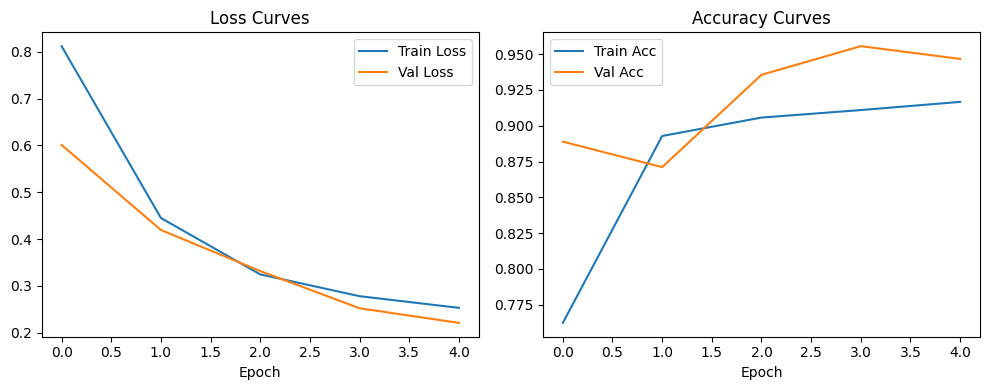

In [ ]:
# ==========================================================
# SECTION 4 — BASELINE MODEL: RESNET-50 TRANSFER LEARNING
# ==========================================================
!pip install torchmetrics --quiet

import torch
import torch.nn as nn
from torchvision import models
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------------------------------------
# 4.1  Load pretrained ResNet-50 and modify head
# ----------------------------------------------------------
num_classes = 3
model = models.resnet50(weights="IMAGENET1K_V2")
for param in model.parameters():
    param.requires_grad = False        # freeze backbone
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
model = model.to(device)

# ----------------------------------------------------------
# 4.2  Loss & optimizer
# ----------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)

# ----------------------------------------------------------
# 4.3  Training loop
# ----------------------------------------------------------
def train_model(model, epochs=5):
    train_acc = MulticlassAccuracy(num_classes=num_classes).to(device)
    val_acc   = MulticlassAccuracy(num_classes=num_classes).to(device)
    train_f1  = MulticlassF1Score(num_classes=num_classes, average="macro").to(device)
    val_f1    = MulticlassF1Score(num_classes=num_classes, average="macro").to(device)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for x, y in tqdm(dl_train, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_acc.update(out, y)
            train_f1.update(out, y)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in tqdm(dl_val, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                val_acc.update(out, y)
                val_f1.update(out, y)

        history["train_loss"].append(running_loss/len(dl_train))
        history["val_loss"].append(val_loss/len(dl_val))
        history["train_acc"].append(train_acc.compute().item())
        history["val_acc"].append(val_acc.compute().item())
        history["train_f1"].append(train_f1.compute().item())
        history["val_f1"].append(val_f1.compute().item())

        print(f"Epoch {epoch+1}: "
              f"Train Acc={history['train_acc'][-1]:.3f}, "
              f"Val Acc={history['val_acc'][-1]:.3f}, "
              f"Train F1={history['train_f1'][-1]:.3f}, "
              f"Val F1={history['val_f1'][-1]:.3f}")

        # reset metrics
        train_acc.reset(); val_acc.reset(); train_f1.reset(); val_f1.reset()

    return history

history = train_model(model, epochs=5)   # change epochs later for full run

# ----------------------------------------------------------
# 4.4  Plot learning curves
# ----------------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss Curves"); plt.xlabel("Epoch")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(); plt.title("Accuracy Curves"); plt.xlabel("Epoch")
plt.tight_layout(); plt.show()


**SECTION 4B — Baseline Evaluation & Confusion Matrix**

Evaluating on Test Set: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]



Classification Report (ResNet-50 Baseline):
                         precision    recall  f1-score   support

    Lung Adenocarcinoma      0.974     0.993     0.983       150
Lung Squamous Carcinoma      0.930     0.800     0.860       150
     Lung Benign Tissue      0.845     0.947     0.893       150

               accuracy                          0.913       450
              macro avg      0.916     0.913     0.912       450
           weighted avg      0.916     0.913     0.912       450



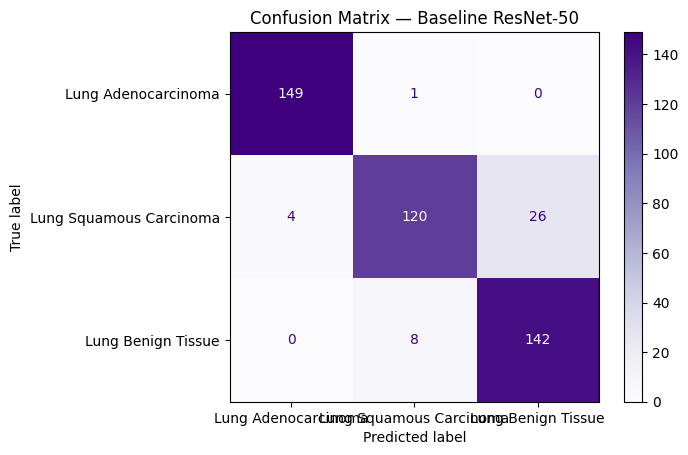

In [ ]:
# ==========================================================
# SECTION 4B — BASELINE EVALUATION (TEST SET)
# ==========================================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in tqdm(dl_test, desc="Evaluating on Test Set"):
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = torch.argmax(out, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Classification report
print("\nClassification Report (ResNet-50 Baseline):")
print(classification_report(
    y_true, y_pred, target_names=[label_map[i] for i in label_map], digits=3
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[label_map[i] for i in label_map])
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix — Baseline ResNet-50")
plt.show()


**SECTION 5 — Ensemble of Pretrained CNNs**

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 149MB/s]


Epoch 1: Val Acc=0.838  Val F1=0.835


Epoch 2: Val Acc=0.900  Val F1=0.898


Epoch 3: Val Acc=0.911  Val F1=0.910


Epoch 4: Val Acc=0.927  Val F1=0.926


Epoch 5: Val Acc=0.922  Val F1=0.921
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]


Epoch 1: Val Acc=0.880  Val F1=0.876


Epoch 2: Val Acc=0.931  Val F1=0.931


Epoch 3: Val Acc=0.929  Val F1=0.928


Epoch 4: Val Acc=0.942  Val F1=0.942


Epoch 5: Val Acc=0.936  Val F1=0.935



Single-model Test Acc/F1:
ResNet-50:   Acc=0.913  F1=0.912
EfficientNet: Acc=0.924  F1=0.924
DenseNet-121:Acc=0.893  F1=0.892

Ensemble Classification Report:
                         precision    recall  f1-score   support

    Lung Adenocarcinoma      0.987     1.000     0.993       150
Lung Squamous Carcinoma      0.901     0.913     0.907       150
     Lung Benign Tissue      0.925     0.900     0.912       150

               accuracy                          0.938       450
              macro avg      0.938     0.938     0.938       450
           weighted avg      0.938     0.938     0.938       450



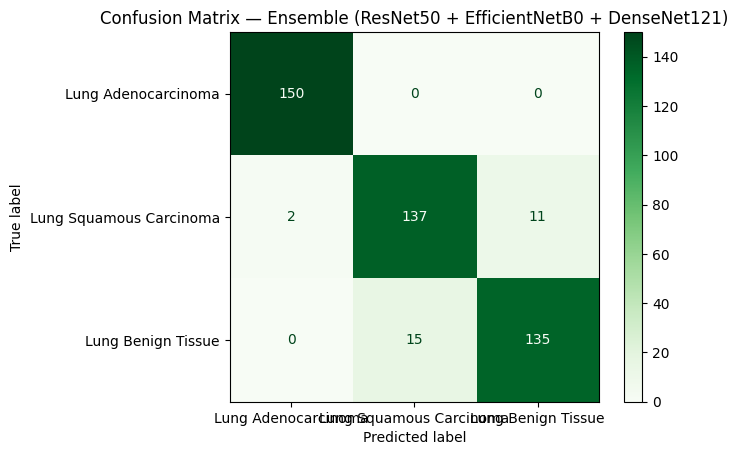

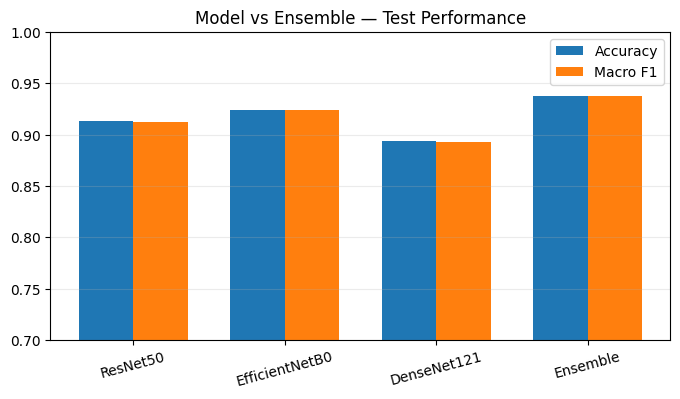

In [ ]:
# ==========================================================
# SECTION 5 — ENSEMBLE OF PRETRAINED CNNS
#   Models: ResNet-50 (already trained), EfficientNet-B0, DenseNet-121
#   Strategy: soft-voting (logit averaging)
# ==========================================================
from torchvision import models
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

num_classes = 3

# ----------------------------------------------------------
# 5.1 Helper: build a frozen-backbone classifier
# ----------------------------------------------------------
def build_frozen_head_model(arch: str):
    if arch == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_feats = m.classifier[1].in_features
        # freeze all
        for p in m.parameters(): p.requires_grad = False
        m.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_feats, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    elif arch == "densenet121":
        m = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        in_feats = m.classifier.in_features
        for p in m.parameters(): p.requires_grad = False
        m.classifier = nn.Sequential(
            nn.Linear(in_feats, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    else:
        raise ValueError("Unknown arch")
    return m.to(device)

# ----------------------------------------------------------
# 5.2 Train EfficientNet-B0 head
# ----------------------------------------------------------
eff = build_frozen_head_model("efficientnet_b0")
opt_eff = torch.optim.Adam(eff.classifier.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train_one_model(model, optimizer, epochs=5):
    acc = MulticlassAccuracy(num_classes=num_classes).to(device)
    f1  = MulticlassF1Score(num_classes=num_classes, average="macro").to(device)
    hist = {"train_loss":[], "val_loss":[], "val_acc":[], "val_f1":[]}
    for ep in range(epochs):
        model.train()
        tl = 0.0
        for x,y in tqdm(dl_train, desc=f"[{model.__class__.__name__}] Train {ep+1}/{epochs}", leave=False):
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out,y)
            loss.backward(); optimizer.step()
            tl += loss.item()
        # val
        model.eval(); vl = 0.0
        with torch.no_grad():
            for x,y in tqdm(dl_val, desc=f"[{model.__class__.__name__}] Val {ep+1}/{epochs}", leave=False):
                x,y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out,y); vl += loss.item()
                acc.update(out,y); f1.update(out,y)
        hist["train_loss"].append(tl/len(dl_train))
        hist["val_loss"].append(vl/len(dl_val))
        hist["val_acc"].append(acc.compute().item())
        hist["val_f1"].append(f1.compute().item())
        print(f"Epoch {ep+1}: Val Acc={hist['val_acc'][-1]:.3f}  Val F1={hist['val_f1'][-1]:.3f}")
        acc.reset(); f1.reset()
    return hist

hist_eff = train_one_model(eff, opt_eff, epochs=5)

# ----------------------------------------------------------
# 5.3 Train DenseNet-121 head
# ----------------------------------------------------------
den = build_frozen_head_model("densenet121")
opt_den = torch.optim.Adam(den.classifier.parameters(), lr=1e-4)
hist_den = train_one_model(den, opt_den, epochs=5)

# ----------------------------------------------------------
# 5.4 Evaluate single models (test set)
# ----------------------------------------------------------
def eval_model(model, loaders):
    model.eval()
    y_true, y_pred, logits_all = [], [], []
    with torch.no_grad():
        for x,y in loaders:
            x,y = x.to(device), y.to(device)
            out = model(x)                # logits
            logits_all.append(out.cpu())
            preds = out.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    logits_all = torch.cat(logits_all, dim=0)
    report = classification_report(
        y_true, y_pred, target_names=[label_map[i] for i in sorted(label_map)], digits=3, output_dict=True
    )
    return y_true, y_pred, logits_all, report

# ResNet-50 from Section 4 is 'model'
y_true, y_pred_r, logits_r, rep_r = eval_model(model, dl_test)
_,      y_pred_e, logits_e, rep_e = eval_model(eff, dl_test)
_,      y_pred_d, logits_d, rep_d = eval_model(den, dl_test)

def acc_from_report(rep): return rep["accuracy"]
def f1_from_report(rep):  return rep["macro avg"]["f1-score"]

print(f"\nSingle-model Test Acc/F1:")
print(f"ResNet-50:   Acc={acc_from_report(rep_r):.3f}  F1={f1_from_report(rep_r):.3f}")
print(f"EfficientNet: Acc={acc_from_report(rep_e):.3f}  F1={f1_from_report(rep_e):.3f}")
print(f"DenseNet-121:Acc={acc_from_report(rep_d):.3f}  F1={f1_from_report(rep_d):.3f}")

# ----------------------------------------------------------
# 5.5 Soft-voting ensemble (average logits)
# ----------------------------------------------------------
avg_logits = (logits_r + logits_e + logits_d) / 3.0
y_pred_ens = avg_logits.argmax(1).numpy()

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
rep_ens = classification_report(
    y_true, y_pred_ens, target_names=[label_map[i] for i in sorted(label_map)], digits=3
)
print("\nEnsemble Classification Report:")
print(rep_ens)

cm_ens = confusion_matrix(y_true, y_pred_ens)
ConfusionMatrixDisplay(cm_ens, display_labels=[label_map[i] for i in sorted(label_map)]) \
    .plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix — Ensemble (ResNet50 + EfficientNetB0 + DenseNet121)")
plt.show()

# ----------------------------------------------------------
# 5.6 Compare metrics (bar chart)
# ----------------------------------------------------------
names = ["ResNet50","EfficientNetB0","DenseNet121","Ensemble"]
accs  = [acc_from_report(rep_r), acc_from_report(rep_e), acc_from_report(rep_d),
         (y_pred_ens==y_true).mean()]
f1s   = [f1_from_report(rep_r), f1_from_report(rep_e), f1_from_report(rep_d),
         classification_report(y_true, y_pred_ens, output_dict=True)["macro avg"]["f1-score"]]

plt.figure(figsize=(8,4))
x = np.arange(len(names))
plt.bar(x-0.18, accs, width=0.36, label="Accuracy")
plt.bar(x+0.18, f1s,  width=0.36, label="Macro F1")
plt.xticks(x, names, rotation=15)
plt.ylim(0.7, 1.0)
plt.title("Model vs Ensemble — Test Performance")
plt.legend(); plt.grid(axis="y", alpha=0.25)
plt.show()


**SECTION 6 — Explainable AI (Grad-CAM on ResNet-50)**

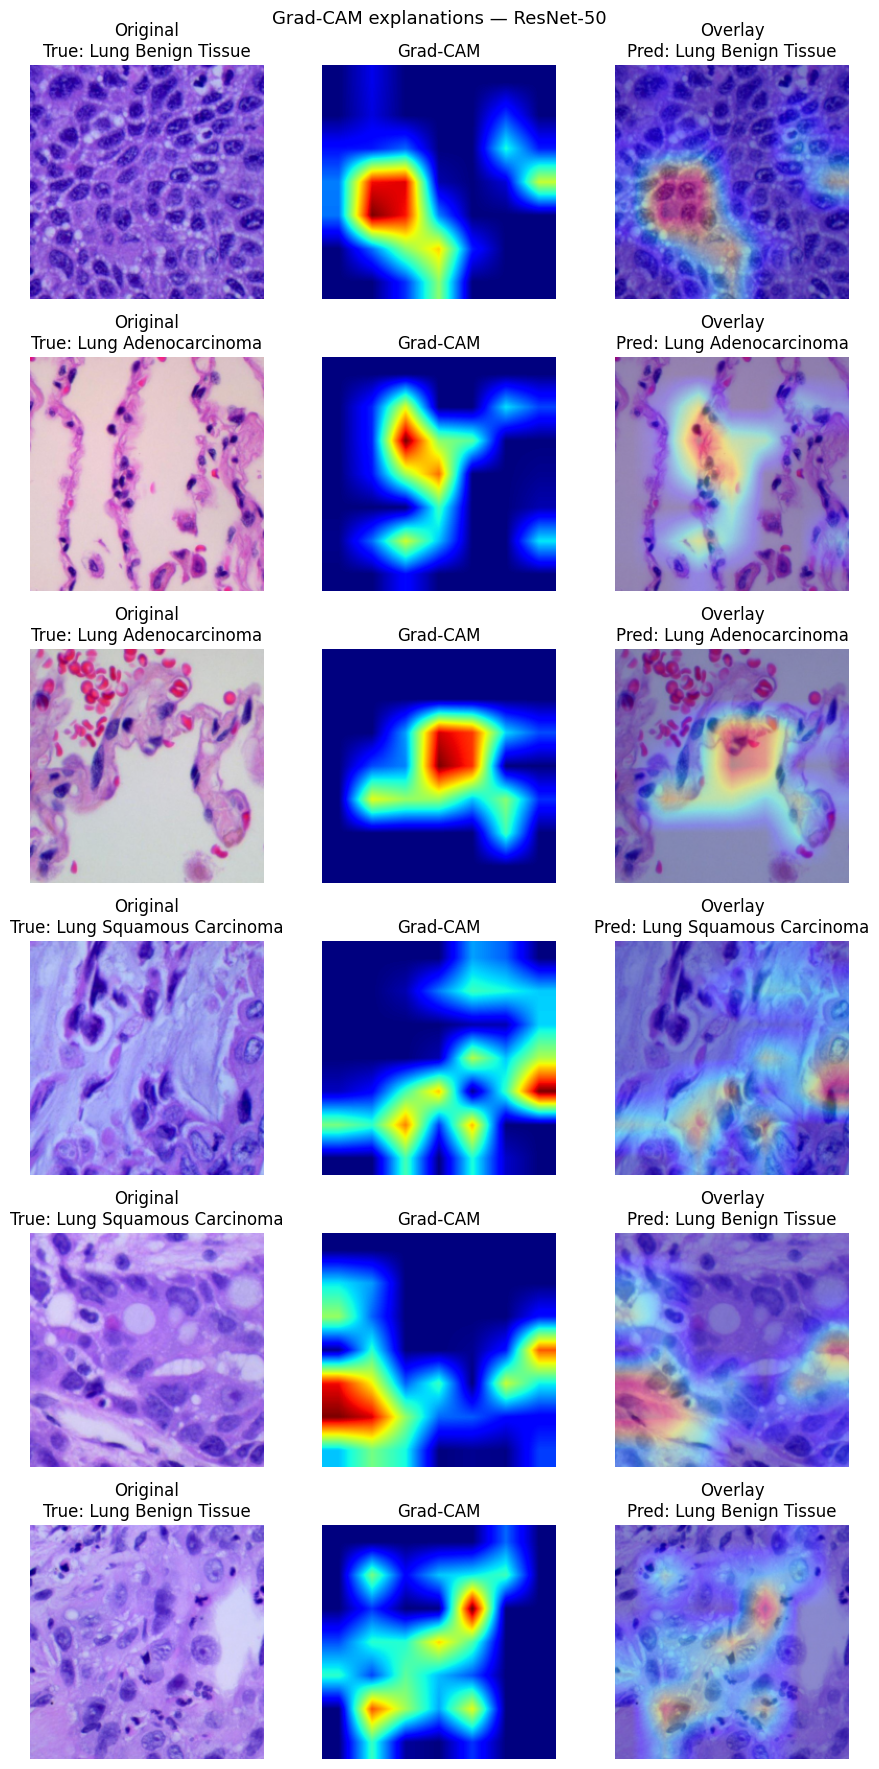

Saved: /content/gradcam_panels/gradcam_panel_resnet50.png


In [ ]:
# ==========================================================
# SECTION 6 — EXPLAINABLE AI (Grad-CAM)
# ==========================================================
import torch, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt, os

model.eval()  # stay in eval, but allow grads during forward/backward

# ----- 6.1: pick target conv layer (ResNet-50 last bottleneck conv) -----
target_layer = model.layer4[-1].conv3
for p in target_layer.parameters():
    p.requires_grad_(True)   # ensure grads can flow to this layer

# holders for activations and grads
feat_maps, grads = [], []

def fwd_hook(module, inp, out):
    feat_maps.append(out)          # DO NOT detach (keep graph)

def bwd_hook(module, grad_in, grad_out):
    grads.append(grad_out[0])      # grad wrt activations

h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)

IM_MEAN = np.array([0.485, 0.456, 0.406])
IM_STD  = np.array([0.229, 0.224, 0.225])

def unnorm_to_rgb(t1):  # 1x3xHxW -> HxWx3 [0,1]
    x = t1[0].detach().cpu().permute(1,2,0).numpy()
    x = (x * IM_STD) + IM_MEAN
    return np.clip(x, 0, 1)

def grad_cam(img_1x3xHxW, class_idx=None):
    """Returns (cam[H,W] in [0,1], predicted_class_idx)."""
    feat_maps.clear(); grads.clear()

    with torch.enable_grad():           # <— IMPORTANT
        x = img_1x3xHxW.to(device)
        x.requires_grad_(True)
        logits = model(x)
        if class_idx is None:
            class_idx = int(logits.argmax(dim=1).item())
        score = logits[:, class_idx]
        model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)

    A = feat_maps[-1]                   # [1,C,h,w]
    G = grads[-1]                       # [1,C,h,w]
    weights = G.mean(dim=(2,3), keepdim=True)           # [1,C,1,1]
    cam = (weights * A).sum(dim=1, keepdim=True)        # [1,1,h,w]
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
    cam = cam[0,0].detach().cpu().numpy()
    cam -= cam.min()
    if cam.max() > 0: cam /= cam.max()
    return cam, class_idx

# ----- 6.2: generate panels & save -----
SAVE_DIR = "/content/gradcam_panels"
os.makedirs(SAVE_DIR, exist_ok=True)

def show_gradcam_examples(dataloader, n_per_class=2):
    got = {0:0,1:0,2:0}
    rows = []
    for x,y in dataloader:
        for i in range(x.size(0)):
            cls = int(y[i].item())
            if got[cls] >= n_per_class:
                continue
            img = x[i:i+1]                        # 1×3×H×W tensor (normalized)
            cam, pred = grad_cam(img, None)
            rgb = unnorm_to_rgb(img)
            heat = plt.cm.jet(cam)[..., :3]
            overlay = 0.35*heat + 0.65*rgb
            rows.append((rgb, heat, overlay, cls, pred))
            got[cls] += 1
            if all(got[k] >= n_per_class for k in got):
                break
        if all(got[k] >= n_per_class for k in got):
            break

    # plot & save
    fig, axes = plt.subplots(len(rows), 3, figsize=(9, 3*len(rows)))
    if len(rows) == 1: axes = np.expand_dims(axes, 0)
    for r,(rgb,heat,overlay,cls,pred) in enumerate(rows):
        axes[r,0].imshow(rgb);     axes[r,0].set_title(f"Original\nTrue: {label_map[cls]}")
        axes[r,1].imshow(heat);    axes[r,1].set_title("Grad-CAM")
        axes[r,2].imshow(overlay); axes[r,2].set_title(f"Overlay\nPred: {label_map[int(pred)]}")
        for c in range(3): axes[r,c].axis("off")
    plt.suptitle("Grad-CAM explanations — ResNet-50", fontsize=13)
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, "gradcam_panel_resnet50.png")
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)

show_gradcam_examples(dl_test, n_per_class=2)

# remove hooks
h1.remove(); h2.remove()
